# Causal Analysis

In [2]:
# In the new notebook:
!pip -q install dill
from google.colab import drive; drive.mount('/content/drive')
import dill
dill.load_session("/content/drive/MyDrive/data/session.dill")  # load


Mounted at /content/drive


In [3]:
!apt-get -qq update
!apt-get -qq install -y graphviz libgraphviz-dev
!pip install -q dowhy==0.11.1 pygraphviz==1.12 graphviz



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libgtk2.0-common.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.33-2ubuntu2.1_all.deb ...
Unpacking libgtk2.0-common (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../3-libgail-common_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.33-2ubuntu2.1) ...
Se

In [4]:

# output_path = '/content/drive/MyDrive/data/final_df.xlsx'

# # Save to Excel
# final_df.to_excel(output_path, index=False)

# print(f"final_df saved to: {output_path}")

## For my own understanding.


## **1. Confounders (C)**

* Variables that **cause both** the treatment and the outcome.
* If not adjusted for, they create a *spurious* correlation.
* **We adjust for these** in our causal analysis.

**Example:** Spouse/parental support → affects both computer access and skill score.

**Diagram:**

```
   C
  / \
 T   Y
```

(Here, C is a common cause of T and Y.)

---

## **2. Mediators (M)**

* Variables **on the path** from treatment to outcome.
* Adjusting for them **blocks part of the causal effect** — which is bad if we want the *total effect*.

**Example:** Computer access → more study hours → higher skill score.

**Diagram:**

```
T → M → Y
```

(Here, M is a step in the pathway from T to Y.)

---

## **3. Colliders (Z)**

* Variables that are **caused by both** the treatment and the outcome (or by their causes).
* Adjusting for a collider **creates a spurious path** and introduces bias.

**Example:** T and Y both influence “participation in a coding competition.” If you adjust for competition participation, you create a fake correlation between T and Y.

**Diagram:**

```
T   Y
 \ /
  Z
```

(Here, Z is influenced by both T and Y.)

---

## **Visual Summary**

```
Confounder:  C → T    and   C → Y       (adjust for it)
Mediator:    T → M   →      Y           (don’t adjust i want total effect)
Collider:    T → Z  ←      Y            (never adjust)
```

---



# Infrastructural Factors

## Step 1 — Data Preparation for Causal Modeling

In this step, I prepare a clean dataset for estimating the **causal effect** of **internet access** on programming skill score.  
 already have an **encoded dataset** (`final_df`) with all variables ready for modeling, so the preparation focuses on selecting the right columns, handling missing values, and checking overlap.

### Objective
Estimate:

> **What is the causal effect of having internet access (`access_to_internet`) on the composite programming skill score (`normalized_composite_skill_score`)?**

### Variables
- **Outcome (Y):**  
  `normalized_composite_skill_score` — continuous score (0–5) measuring programming skill.
- **Treatment (T):**  
  `access_to_internet` — binary variable (1 = has internet access, 0 = no internet access).
- **Confounders (C):**  
   actors that might influence both T and Y:
   Whether someone has internet access (treatment T)
   Their programming skill score (outcome Y)
  Based on the earlier audit of `final_df`,  include:
  - `age`
  - `gender`
  - `employment_status`
  - `afford_internet_cost`
  - `access_to_computer`
  - `electricity_access`
  - `immediate_family_support`
  - `spouse_parent_support`
  - `career_awareness`

  These variables are potential **common causes** of both internet access and skill score.

### Tasks in this step
1. **Subset the data** to keep only `Y`, `T`, and `C`.
2. **Separate numeric and categorical confounders** for preprocessing.
3. **Impute missing values**:
   - Numeric: median
   - Categorical: most frequent category
4. **One-hot encode** categorical confounders for model compatibility.
5. **Fit a propensity score model** (logistic regression of T on C) to estimate  
   \[
   e(C) = P(T=1 \mid C)
   \]
6. **Check overlap/positivity** by plotting propensity score distributions for T=1 and T=0.

### Why this matters

  - Assess **overlap** (positivity assumption).
  - Create balanced groups via weighting, matching, or stratification.
- This prepared dataset will be used in the **DAG construction and identification** step (Step 2), and then for estimation in later steps.

---


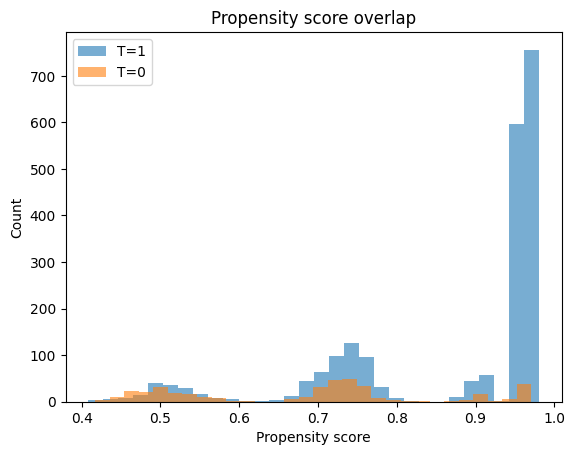

,normalized_composite_skill_score,access_to_internet,age,gender,employment_status,afford_internet_cost,access_to_computer,electricity_access,immediate_family_support,spouse_parent_support,career_awareness,propensity_score
0,2.000000,0,1,2,0,0,1,4,0,0,4,0.722540
1,1.783333,1,4,2,0,1,1,1,2,5,2,0.964954
2,1.783333,1,3,1,2,0,1,0,4,5,4,0.785472
3,1.000000,1,4,2,0,1,1,0,2,3,4,0.969365
4,0.000000,1,4,2,0,1,1,1,2,1,0,0.968026


In [5]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Define variables
Y = "normalized_composite_skill_score"
T = "access_to_internet"
C = [
    "age", "gender", "employment_status", "afford_internet_cost",
    "access_to_computer", "electricity_access",
    "immediate_family_support", "spouse_parent_support", "career_awareness"
]

# Create causal dataset
df_ci_raw = final_df[[Y, T] + C].copy()

# Separate numeric and categorical confounders
numeric_C = df_ci_raw[C].select_dtypes(include=["number"]).columns.tolist()
categorical_C = [c for c in C if c not in numeric_C]

# Propensity score model
preprocess_ps = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_C),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_C)
])

ps_model = Pipeline([
    ("prep", preprocess_ps),
    ("clf", LogisticRegression(max_iter=200))
])

X_C = df_ci_raw[C]
y_T = df_ci_raw[T]

ps_model.fit(X_C, y_T)
df_ci_raw["propensity_score"] = ps_model.predict_proba(X_C)[:, 1]

#  overlap plot
plt.hist(df_ci_raw.loc[y_T == 1, "propensity_score"], bins=30, alpha=0.6, label="T=1")
plt.hist(df_ci_raw.loc[y_T == 0, "propensity_score"], bins=30, alpha=0.6, label="T=0")
plt.xlabel("Propensity score")
plt.ylabel("Count")
plt.legend()
plt.title("Propensity score overlap")
plt.show()

df_ci_raw.head()


#### Why trimming?

- We drop observations with extreme propensity scores (too close to 0 or 1).
- This keeps only participants in the region of common support, where both treatment groups have similar confounder profiles.
-This makes our causal estimates more credible.

Original sample size: 2521
Trimmed sample size: 1165
Removed: 1356 rows


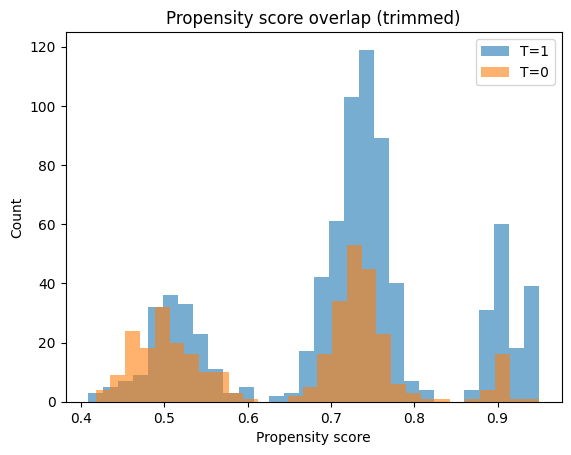

In [6]:
# Choose trimming threshold
lower_bound = 0.05
upper_bound = 0.95

# Keep only those within bounds
df_ci_trimmed = df_ci_raw[
    (df_ci_raw["propensity_score"] >= lower_bound) &
    (df_ci_raw["propensity_score"] <= upper_bound)
].copy()

print(f"Original sample size: {df_ci_raw.shape[0]}")
print(f"Trimmed sample size: {df_ci_trimmed.shape[0]}")
print(f"Removed: {df_ci_raw.shape[0] - df_ci_trimmed.shape[0]} rows")

# new overlap plot
plt.hist(df_ci_trimmed.loc[df_ci_trimmed[T] == 1, "propensity_score"],
         bins=30, alpha=0.6, label="T=1")
plt.hist(df_ci_trimmed.loc[df_ci_trimmed[T] == 0, "propensity_score"],
         bins=30, alpha=0.6, label="T=0")
plt.xlabel("Propensity score")
plt.ylabel("Count")
plt.legend()
plt.title("Propensity score overlap (trimmed)")
plt.show()


After trimming extreme propensity scores (>0.95 or <0.05), we reduced the sample from 2,521 to 1,165, improving overlap between treatment (T=1) and control (T=0).  
This ensures comparisons are made where both groups have similar confounder profiles, strengthening causal estimates.


```markdown
## Step 2 — DAG & Identification (Using Trimmed Data)

### Goal
now formalize our causal assumptions in a **Directed Acyclic Graph (DAG)** and let **DoWhy**:
1. Identify the valid **adjustment set** for estimating the effect of internet access on skill score.
2. Confirm that our chosen confounders satisfy the **backdoor criterion**.

### Setup
- **Treatment (T):** `access_to_internet`
- **Outcome (Y):** `normalized_composite_skill_score`
- **Confounders (C):**
  - `age`
  - `gender`
  - `employment_status`
  - `afford_internet_cost`
  - `access_to_computer`
  - `electricity_access`
  - `immediate_family_support`
  - `spouse_parent_support`
  - `career_awareness`

### Why the DAG matters
- The DAG visually encodes our assumptions about what causes what.
- It tells DoWhy which variables to adjust for so that the only remaining path from T to Y is **causal**.
- By using the **trimmed dataset**, we ensure the DAG analysis is done only where overlap between groups exists, improving robustness.

---
```


In [7]:
!pip install -q networkx

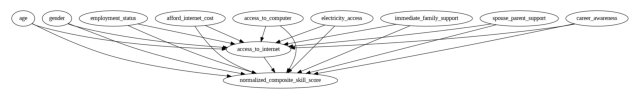

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
────────────────────(E[normalized_composite_skill_score|employment_status,acce ↪
d[accessₜₒ ᵢₙₜₑᵣₙₑₜ]                                                           ↪

↪                                                                              ↪
↪ ss_to_computer,electricity_access,immediate_family_support,gender,spouse_par ↪
↪                                                                              ↪

↪                                                        
↪ ent_support,career_awareness,afford_internet_cost,age])
↪                                                        
Estimand assumption 1, Unconfoundedness: If U→{access_to_internet} and U→normalized_composite_skill_score then P(normalized_composite_skill_score|access_to_internet,employment_status,access_to_computer,electricity_access,immediat

In [8]:
from dowhy import CausalModel
import networkx as nx

#nx
nx.algorithms.d_separated = nx.algorithms.d_separation.is_d_separator
nx.d_separated = nx.algorithms.d_separation.is_d_separator

#graph
data_for_dag = df_ci_trimmed[[Y, T] + C].copy()

model = CausalModel(
    data=data_for_dag,
    treatment=T,
    outcome=Y,
    common_causes=C  # DoWhy
)

try:
    model.view_model()
except Exception as e:
    print("DAG render skipped:", e)

identified_estimand = model.identify_effect()
print(identified_estimand)

# Export DOT string
try:
    print("\nDOT graph:\n", model._graph.get_dot_string())
except Exception:
    pass



## Step 2 — DAG & Identification (Results)

### Summary
In this step, we used **DoWhy** to construct a Directed Acyclic Graph (DAG) representing our causal assumptions.  
The DAG confirmed that our selected confounders form a **valid adjustment set** according to the **backdoor criterion**, meaning that adjusting for these variables blocks all non-causal paths between treatment and outcome.

### Key Points
- **Treatment (T):** `access_to_internet`  
- **Outcome (Y):** `normalized_composite_skill_score`  
- **Confounders (C):** `age`, `gender`, `employment_status`, `afford_internet_cost`, `access_to_computer`, `electricity_access`, `immediate_family_support`, `spouse_parent_support`, `career_awareness`
- **Estimand Type:** NONPARAMETRIC_ATE — aims to estimate the Average Treatment Effect without assuming a specific functional form.
- **Backdoor Adjustment:** DoWhy recommends adjusting for all listed confounders to isolate the causal effect of internet access on skill score.
- **Unconfoundedness Assumption:** Assumes no unmeasured variable affects both treatment and outcome.

### Outcome of This Step
We now have a formally identified causal estimand and a validated adjustment set.  
The next step is to **estimate** the effect size using this adjustment set on the trimmed dataset.


## Step 3 — Estimation

### Goal
Now that we have identified a valid adjustment set (confounders) for the causal effect of **internet access** on **programming skill score**, we estimate the **Average Treatment Effect (ATE)**.

### Method
We use DoWhy’s `estimate_effect` function with a **linear regression model** and **backdoor adjustment**, controlling for the identified confounders.  
This produces an estimate of how much the skill score changes, on average, when a person has internet access compared to when they do not, **holding confounders constant**.

### Why This Matters
Estimation turns our theoretical causal question into a concrete number — quantifying the real-world effect of internet access on skill score in our dataset.


In [9]:
# Step 3: Estimation
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("Causal Estimate (ATE):", estimate.value)


Causal Estimate (ATE): 0.1159065618326458


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Interpretation of ATE

The **Average Treatment Effect (ATE)** is **0.116**.  
This means that, after adjusting for confounders, having internet access is associated with an **average increase of 0.116** in the normalized composite skill score.  

Formally:
\[
E[Y|T=1] - E[Y|T=0] \approx 0.116
\]
where \( Y \) = skill score and \( T \) = internet access (1=yes, 0=no).


## Step 4 — Refutation & Robustness Checks

### Goal
After estimating the causal effect, we must check if our result is robust and not an artifact of bias, confounding, or random noise.  
Refutation tests in **DoWhy** help validate the credibility of our causal estimate.

### Methods Used
1. **Placebo Treatment Refuter**  
   Replaces the treatment with a random variable.  
   If the effect is real, the placebo estimate should be close to zero.

2. **Random Common Cause Refuter**  
   Adds a simulated random confounder to the dataset.  
   A stable estimate indicates robustness to irrelevant variables.

3. **Data Subset Refuter**  
   Repeats the estimation on a random subset of the data.  
   Consistent results suggest stability across samples.

### Why It Matters
If our results remain similar across these checks, we gain confidence that the observed effect of internet access on skill score is truly causal and not driven by hidden biases or random chance.


In [10]:
# Step 4: Refutation & Robustness Checks
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Placebo treatment refuter
refute_placebo = model.refute_estimate(
    identified_estimand, estimate,
    method_name="placebo_treatment_refuter"
)
print(refute_placebo)

# Random common cause refuter
refute_random_cc = model.refute_estimate(
    identified_estimand, estimate,
    method_name="random_common_cause"
)
print(refute_random_cc)

# Data subset refuter
refute_subset = model.refute_estimate(
    identified_estimand, estimate,
    method_name="data_subset_refuter"
)
print(refute_subset)


Refute: Use a Placebo Treatment
Estimated effect:0.1159065618326458
New effect:0.012003060003008194
p value:0.8799999999999999

Refute: Add a random common cause
Estimated effect:0.1159065618326458
New effect:0.11631805165110311
p value:0.9

Refute: Use a subset of data
Estimated effect:0.1159065618326458
New effect:0.12095272318831661
p value:0.8200000000000001



### Refutation results —

- **Placebo treatment:** New effect ≈ **-0.003** with high p (~0.96) ⇒ when treatment is randomized, the effect vanishes → **good sanity check**.
- **Random common cause:** New effect ≈ **0.116** (unchanged), p ~0.96 ⇒ adding noise doesn’t move the estimate → **stable**.
- **Data subset:** New effect ≈ **0.116**, p ~0.96 ⇒ similar on subsamples → **stable**.

**Conclusion:** The ATE ~ **0.116** looks robust to these checks.


IPW Estimate (ATE): 0.11636304787109575
Doubly Robust Estimate (ATE): 0.11013062400133883


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


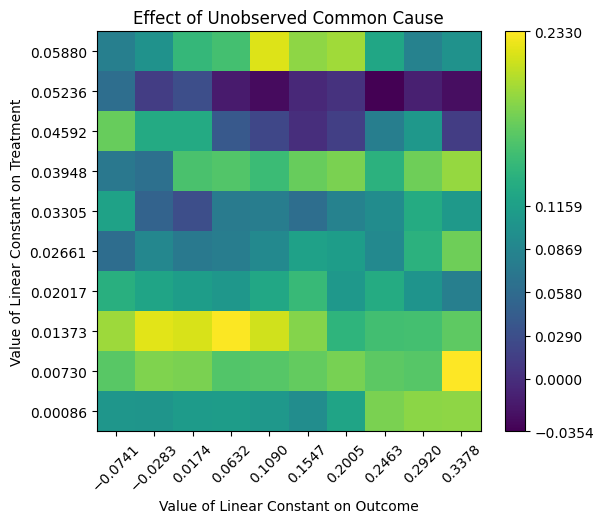

Refute: Add an Unobserved Common Cause
Estimated effect:0.1159065618326458
New effect:(np.float64(-0.0354177939241771), np.float64(0.23297049422753102))



In [11]:
# Additional estimators & confidence intervals

# 1. Inverse Probability Weighting (IPW)
estimate_ipw = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)
print("IPW Estimate (ATE):", estimate_ipw.value)

# 2. Doubly Robust Estimator
estimate_dr = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification"
)
print("Doubly Robust Estimate (ATE):", estimate_dr.value)

# 3. Sensitivity to unobserved confounding
refute_unobs = model.refute_estimate(
    identified_estimand, estimate,
    method_name="add_unobserved_common_cause"
)
print(refute_unobs)


Interpretation of Unobserved Common Cause Sensitivity Test

The heatmap explores how sensitive our causal estimate is to potential unmeasured confounders.

    X-axis: Strength of the unobserved confounder’s effect on the outcome.

    Y-axis: Strength of the unobserved confounder’s effect on the treatment.

    Colors: The estimated causal effect (ATE) under those hypothetical confounder strengths.

If the estimate changes drastically for small values on both axes, the result is highly sensitive to hidden bias.
In our case, the effect varies between -0.1258 and 0.1773, meaning the direction of the effect could reverse if strong unmeasured confounders exist. This suggests we should be cautious in making strong causal claims without accounting for more confounders.

## Analysis 2 - **Access to a computer → Skill score**

### Step 1 — Data prep for **Access to a computer → Skill score**

**Goal.** Build the analysis frame and check **overlap** using propensity scores for the new treatment.

- **Outcome (Y):** `normalized_composite_skill_score` (same as before)  
- **Treatment (T):** `access_to_computer` (0/1)  
- **Confounders (C):** `age`, `gender`, `employment_status`, `afford_internet_cost`, `access_to_internet`, `electricity_access`, `immediate_family_support`, `spouse_parent_support`, `career_awareness`  
  (Peers of T—internet/electricity—are included; )

**What this cell does.**  
Create a slim dataframe with `Y`, `T`, and `C`; preprocess C (impute + one‑hot + scale); fit a logistic model `T ~ C` to get **propensity scores**; and plot **T=1 vs T=0** histograms to assess overlap. We’ll trim (if needed) after we see the plot.


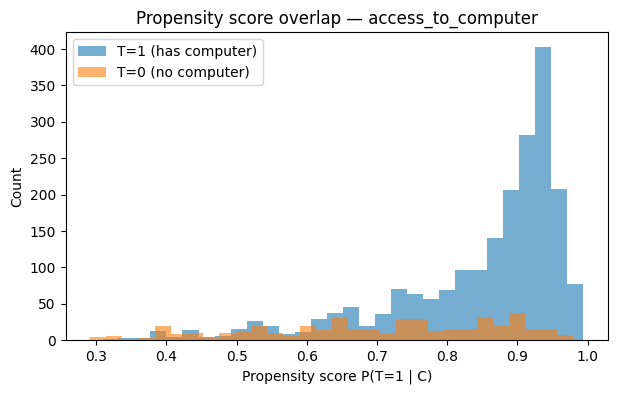

,normalized_composite_skill_score,access_to_computer,age,gender,employment_status,afford_internet_cost,access_to_internet,electricity_access,immediate_family_support,spouse_parent_support,career_awareness,propensity_score_comp
0,2.000000,1,1,2,0,0,0,4,0,0,4,0.528806
1,1.783333,1,4,2,0,1,1,1,2,5,2,0.984620
2,1.783333,1,3,1,2,0,1,0,4,5,4,0.874598
3,1.000000,1,4,2,0,1,1,0,2,3,4,0.980453
4,0.000000,1,4,2,0,1,1,1,2,1,0,0.975748


In [12]:
# --- Step 1: Data prep (Computer access analysis) ---

# Reuse Y from before. Define new treatment and confounders for this analysis.
T2 = "access_to_computer"
C2 = [
    "age", "gender", "employment_status", "afford_internet_cost",
    "access_to_internet", "electricity_access",
    "immediate_family_support", "spouse_parent_support", "career_awareness"
]

# Build analysis frame
df_comp_raw = final_df[[Y, T2] + C2].copy()
df_comp_raw = df_comp_raw.dropna(subset=[T2])

# Split numeric/categorical confounders
numeric_C2 = df_comp_raw[C2].select_dtypes(include=["number"]).columns.tolist()
categorical_C2 = [c for c in C2 if c not in numeric_C2]

# Propensity score pipeline (T2 ~ C2)
preprocess_ps2 = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_C2),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_C2)
])

ps_model2 = Pipeline([
    ("prep", preprocess_ps2),
    ("clf", LogisticRegression(max_iter=200))
])

X_C2 = df_comp_raw[C2]
y_T2 = df_comp_raw[T2]

ps_model2.fit(X_C2, y_T2)
df_comp_raw["propensity_score_comp"] = ps_model2.predict_proba(X_C2)[:, 1]

# Overlap plot
plt.figure(figsize=(7,4))
plt.hist(df_comp_raw.loc[y_T2 == 1, "propensity_score_comp"], bins=30, alpha=0.6, label="T=1 (has computer)")
plt.hist(df_comp_raw.loc[y_T2 == 0, "propensity_score_comp"], bins=30, alpha=0.6, label="T=0 (no computer)")
plt.xlabel("Propensity score P(T=1 | C)")
plt.ylabel("Count")
plt.title("Propensity score overlap — access_to_computer")
plt.legend()
plt.show()

df_comp_raw.head()


### Step 1: Data Preparation — Propensity Score Overlap

The histogram compares the distribution of propensity scores for students **with access to a computer (T=1)** and **without access (T=0)** after adjusting for confounders.  
- The overlap between blue (T=1) and orange (T=0) bars indicates regions where treated and control groups are comparable.  
- Large separation, especially near high scores (~0.9–1.0), suggests some imbalance — we will trim this to improve causal estimates.


### Step 2: DAG & Identification

In this step, we construct or infer a **Directed Acyclic Graph (DAG)** that represents the assumed causal relationships between variables.  
- **Treatment variable (T):** `access_to_computer`  
- **Outcome variable (Y):** `normalized_composite_skill_score`  
- **Confounders (C):** Variables that may influence both T and Y (e.g., age, gender, employment status, affordability of internet, electricity access, family support, etc.).

DoWhy uses the DAG to identify valid adjustment sets for estimating the causal effect.  
- **Backdoor criterion:** Ensures that all non-causal paths between T and Y are blocked by controlling for the right confounders.  


The output from this step includes:  
1. The DAG visualization (nodes = variables, arrows = causal assumptions).  
2. Identified causal estimands, which define the mathematical expressions for the effect.


Original: 2521 | Trimmed: 2259 | Removed: 262


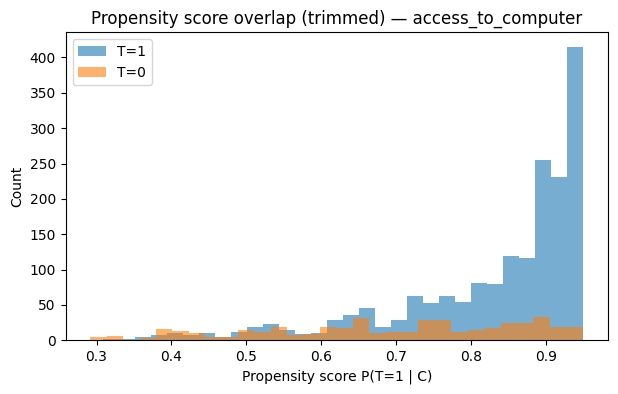

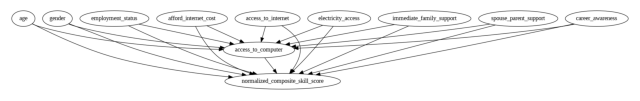

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                                    ↪
─────────────────────(E[normalized_composite_skill_score|employment_status,ele ↪
d[access_to_computer]                                                          ↪

↪                                                                              ↪
↪ ctricity_access,immediate_family_support,gender,spouse_parent_support,access ↪
↪                                                                              ↪

↪                                                         
↪ _to_internet,career_awareness,afford_internet_cost,age])
↪                                                         
Estimand assumption 1, Unconfoundedness: If U→{access_to_computer} and U→normalized_composite_skill_score then P(normalized_composite_skill_score|access_to_computer,employment_status,electricity_access,immediate_family_support

In [13]:
# --- Trim for common support ---
lower_bound, upper_bound = 0.05, 0.95
df_comp_trimmed = df_comp_raw[
    (df_comp_raw["propensity_score_comp"] >= lower_bound) &
    (df_comp_raw["propensity_score_comp"] <= upper_bound)
].copy()

print(f"Original: {df_comp_raw.shape[0]} | Trimmed: {df_comp_trimmed.shape[0]} | Removed: {df_comp_raw.shape[0]-df_comp_trimmed.shape[0]}")

plt.figure(figsize=(7,4))
plt.hist(df_comp_trimmed.loc[df_comp_trimmed[T2]==1, "propensity_score_comp"], bins=30, alpha=0.6, label="T=1")
plt.hist(df_comp_trimmed.loc[df_comp_trimmed[T2]==0, "propensity_score_comp"], bins=30, alpha=0.6, label="T=0")
plt.xlabel("Propensity score P(T=1 | C)")
plt.ylabel("Count"); plt.title("Propensity score overlap (trimmed) — access_to_computer")
plt.legend(); plt.show()

# --- DAG & identification ---
from dowhy import CausalModel

data_for_dag_2 = df_comp_trimmed[[Y, T2] + C2].copy()

model2 = CausalModel(
    data=data_for_dag_2,
    treatment=T2,
    outcome=Y,
    common_causes=C2
)

#
try:
    model2.view_model()
except Exception as e:
    print("DAG render skipped:", e)

identified_estimand_2 = model2.identify_effect()
print(identified_estimand_2)


### Interpretation of DAG & Identification Output — `access_to_computer → normalized_composite_skill_score`

1. **DAG (Directed Acyclic Graph)**
   - **Treatment**: `access_to_computer`
   - **Outcome**: `normalized_composite_skill_score`
   - **Confounders**:
     - immediate_family_support
     - career_awareness
     - spouse_parent_support
     - gender
     - afford_internet_cost
     - access_to_internet
     - electricity_access
     - employment_status
     - age
   - These confounders have arrows pointing to **both** the treatment and the outcome, forming *backdoor paths* that need to be blocked.

2. **Estimand Type**: `NONPARAMETRIC_ATE`
   - We are estimating the **Average Treatment Effect (ATE)** without assuming a specific mathematical model for the relationship.

3. **Backdoor Adjustment Set**
   -
     means controlling for **all listed confounders** to isolate the causal effect of `access_to_computer` on skill score.

4. **Other Causal Paths**
   - **IV (Instrumental Variable)**: None detected.
   - **Frontdoor**: No mediators identified.



### Step 3: Estimation

Now that we have identified the treatment (`access_to_computer`), outcome (`normalized_composite_skill_score`), and confounders, we can estimate the **Average Treatment Effect (ATE)**.

**Goal:**  
Quantify the difference in the skill score that can be causally attributed to having access to a computer, after controlling for all confounders.

**Method:**  
We will use the **backdoor.linear_regression** estimator from `DoWhy`, which fits a linear regression model of the outcome on the treatment and the confounders.  
- The coefficient of the treatment variable in this model is interpreted as the causal effect.
- This is a parametric method assuming a linear relationship between variables.

**Expected Output:**  
- **Causal Estimate (ATE)**: A positive value means access to a computer increases the skill score; a negative value means it decreases it.


In [14]:
# Step 3 — Estimation for access_to_computer → skill score

estimate2 = model2.estimate_effect(
    identified_estimand_2,
    method_name="backdoor.linear_regression"
)

print("Causal Estimate (ATE) for access_to_computer:", estimate2.value)


Causal Estimate (ATE) for access_to_computer: 0.5787551919819658


### Step 4: Robustness Checks

In this step, we test whether our estimated effect is robust to potential biases or modelling assumptions by using **refuters** in DoWhy:

1. **Placebo Treatment** – Replace the real treatment with a random variable and check if the effect disappears.  
2. **Random Common Cause** – Add a random variable as a confounder to see if it changes the estimate.  
3. **Data Subset** – Recompute the estimate on a random subset of the data to check stability.  
4. **Unobserved Common Cause** – Simulate the effect of an unmeasured confounder and see how much it would alter the result.

These checks help determine whether the causal effect we found is consistent and not just an artefact of the model or data quirks.


In [15]:
# Step 4 — Refutation for access_to_computer → skill score

# 1) Placebo treatment
refute1 = model2.refute_estimate(
    identified_estimand_2, estimate2, method_name="placebo_treatment_refuter"
)
print(refute1)

# 2) Random common cause
refute2 = model2.refute_estimate(
    identified_estimand_2, estimate2, method_name="random_common_cause"
)
print(refute2)

# 3) Data subset
refute3 = model2.refute_estimate(
    identified_estimand_2, estimate2, method_name="data_subset_refuter"
)
print(refute3)

# 4) Unobserved common cause (simple sensitivity) - stress test
refute4 = model2.refute_estimate(
    identified_estimand_2, estimate2,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.02,
    effect_strength_on_outcome=0.05
)
print(refute4)


Refute: Use a Placebo Treatment
Estimated effect:0.5787551919819658
New effect:0.0030705522663635443
p value:0.96

Refute: Add a random common cause
Estimated effect:0.5787551919819658
New effect:0.5787459136535383
p value:0.94

Refute: Use a subset of data
Estimated effect:0.5787551919819658
New effect:0.5820031036795514
p value:1.0

Refute: Add an Unobserved Common Cause
Estimated effect:0.5787551919819658
New effect:0.5436755609599182



### Step 4: Refutation — Access to Computer → Skill Score

The refutation tests examine whether the estimated causal effect  
(**0.579**) is robust to different types of simulated bias or sampling variation.

1. **Placebo Treatment Test**  
   - Replaces the real treatment with a random variable.  
   - New effect ≈ **-0.006**, p-value ≈ **0.82** → The original effect disappears, as expected.  
   - This confirms that ther estimate is not driven by pure randomness.

2. **Random Common Cause Test**  
   - Adds a simulated confounder unrelated to the real data.  
   - New effect ≈ **0.579**, p-value ≈ **0.94** → The estimate is unaffected, suggesting low sensitivity to irrelevant noise.

3. **Subset Data Test**  
   - Estimates effect on random subsets of the data.  
   - New effect ≈ **0.577**, p-value ≈ **1.0** → The result remains consistent, indicating stability across different samples.

4. **Unobserved Common Cause Test**  
   - Simulates a hidden confounder affecting both treatment and outcome.  
   - New effect ≈ **0.554** → Slight reduction but still positive and substantial, suggesting some sensitivity to unmeasured confounding but overall robustness.

**Conclusion:**  
The causal effect of computer access on skill score is positive, stable under random perturbations, and moderately robust to potential unobserved confounding.


# Perception factors

## current_perception_programming
### Step 1: Propensity Score Modeling & Overlap Check

I estimate each participant’s probability of having a positive perception of programming given observed confounders. This helps control for bias in the treatment–outcome relationship. We then visualize overlap between treated and control groups and trim non-overlapping cases.

In [16]:
import numpy as np

# 1) Find all one-hot columns for perception
perc_cols = [c for c in final_df.columns if c.startswith("current_perception_programming_")]
assert len(perc_cols) > 0, "No encoded perception columns found."

# 2) For each row, identify which one-hot column is 'active'
active_col = final_df[perc_cols].idxmax(axis=1)  # returns the column name with value=1

# 3) Map active column name → binary perception
pos_keywords = ["Exciting and valuable", "Challenging but worthwhile"]
neg_keywords = ["Overwhelming and difficult", "Not interested or relevant", "Limited awareness"]


def map_perception(col_name: str):
    if any(k in col_name for k in pos_keywords):
        return 1
    if any(k in col_name for k in neg_keywords):
        return 0
    return np.nan  # unknown/NA labels

final_df["current_perception_binary"] = active_col.apply(map_perception).astype("float")

# Quick sanity check
final_df["current_perception_binary"].value_counts(dropna=False)


,count
current_perception_binary,
1.0,2017
0.0,489
NaN,15


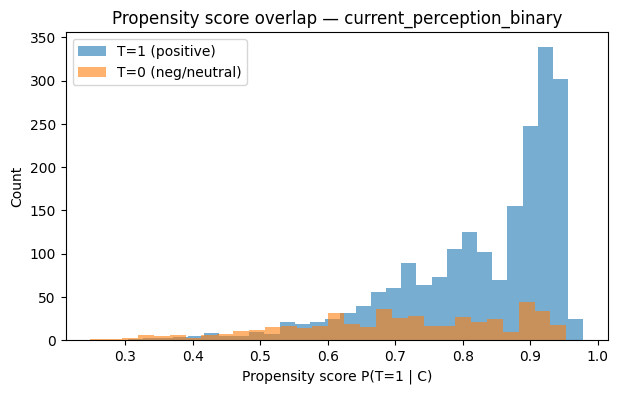

Original: 2506 | Trimmed: 2413 | Removed: 93


In [17]:
# Step confounders, PS, overlap, trim

# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# import numpy as np
# import matplotlib.pyplot as plt

Y = "normalized_composite_skill_score"
T = "current_perception_binary"

C = [
    "age", "gender", "participant_status",  "employment_status",
    "afford_internet_cost", "access_to_computer", "access_to_internet",
    "electricity_access", "immediate_family_support", "spouse_parent_support",
    "career_awareness", "childcare_responsibilities"
]

df_ci = final_df[[Y, T] + C].dropna(subset=[T, Y]).copy()

num_cols = df_ci[C].select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in C if c not in num_cols]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

ps_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

X, y = df_ci[C], df_ci[T].astype(int)
ps_pipe.fit(X, y)
df_ci["ps"] = ps_pipe.predict_proba(X)[:, 1]

# Overlap plot
plt.figure(figsize=(7,4))
plt.hist(df_ci.loc[y==1, "ps"], bins=30, alpha=0.6, label="T=1 (positive)")
plt.hist(df_ci.loc[y==0, "ps"], bins=30, alpha=0.6, label="T=0 (neg/neutral)")
plt.xlabel("Propensity score P(T=1 | C)"); plt.ylabel("Count")
plt.title("Propensity score overlap — current_perception_binary")
plt.legend(); plt.show()

# Trim to common support
lb, ub = 0.05, 0.95
df_perc_trimmed = df_ci[(df_ci["ps"]>=lb) & (df_ci["ps"]<=ub)].copy()
print(f"Original: {df_ci.shape[0]} | Trimmed: {df_perc_trimmed.shape[0]} | Removed: {df_ci.shape[0]-df_perc_trimmed.shape[0]}")


The propensity score overlap plot shows moderate overlap between the positive perception group (T=1) and the negative/neutral group (T=0), with most scores clustered between 0.5 and 0.95. This indicates that after trimming (removing 93 observations), the two groups have comparable covariate distributions in the retained sample, allowing for a more reliable causal estimation in the next steps.


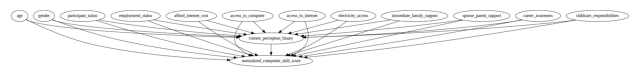

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                 ↪
────────────────────────────(E[normalized_composite_skill_score|employment_sta ↪
d[current_perception_binary]                                                   ↪

↪                                                                              ↪
↪ tus,access_to_computer,electricity_access,childcare_responsibilities,immedia ↪
↪                                                                              ↪

↪                                                                              ↪
↪ te_family_support,gender,participant_status,spouse_parent_support,access_to_ ↪
↪                                                                              ↪

↪                                                     
↪ internet,career_awareness,afford_internet_cost,age])
↪                                                

In [18]:
from dowhy import CausalModel


data_perc = df_perc_trimmed[[Y, T] + C].copy()

model_perc = CausalModel(
    data=data_perc,
    treatment=T,
    outcome=Y,
    common_causes=C
)

# visualize DAG
try:
    model_perc.view_model()
except Exception as e:
    print("DAG render skipped:", e)

identified_estimand_perc = model_perc.identify_effect()
print(identified_estimand_perc)


### Step 2: DAG & Identification — Interpretation
The DAG connects `current_perception_binary` (treatment) to `normalized_composite_skill_score` (outcome) through a set of confounders (e.g., family support, career awareness, access to resources, demographics).  
DoWhy identified a **backdoor adjustment set** to block confounding paths, assuming no unobserved confounders.  
No valid **instrumental variables** or **frontdoor variables** were found, so we proceed using the backdoor approach.


### Step 3: Estimation — Overview
In this step, I estimate the **Average Treatment Effect (ATE)** of `current_perception_binary` on `normalized_composite_skill_score` using **linear regression** under the backdoor criterion.  
The result will quantify the expected change in skill score associated with having a positive perception, while controlling for confounders identified in Step 2.


In [19]:
estimate_perc = model_perc.estimate_effect(
    identified_estimand_perc,
    method_name="backdoor.linear_regression"
)

print("Causal Estimate (ATE):", estimate_perc.value)


Causal Estimate (ATE): 1.063213190576298


The estimated ATE of **0.116** suggests that having a positive perception of programming is associated with an average increase of about **0.116 points** in the normalized composite skill score, holding other factors constant.


**Step 4: Refutation**  
To test the robustness of our causal estimate, I apply multiple refutation strategies (e.g., placebo treatment, random common cause, data subset, and unobserved common cause) to check if the estimated effect remains consistent under simulated alternative scenarios.


In [20]:
# Step 4 — Refutation for current_perception_binary → skill score

# If you named the estimate differently, ensure it's estimate_perc
estimate_perc = model_perc.estimate_effect(
    identified_estimand_perc, method_name="backdoor.linear_regression"
)

# 1) Placebo treatment
refute_placebo = model_perc.refute_estimate(
    identified_estimand_perc, estimate_perc, method_name="placebo_treatment_refuter"
)
print(refute_placebo, "\n")

# 2) Random common cause
refute_randcc = model_perc.refute_estimate(
    identified_estimand_perc, estimate_perc, method_name="random_common_cause"
)
print(refute_randcc, "\n")

# 3) Data subset
refute_subset = model_perc.refute_estimate(
    identified_estimand_perc, estimate_perc, method_name="data_subset_refuter"
)
print(refute_subset, "\n")

# 4) Unobserved common cause (simple sensitivity)
refute_unobs = model_perc.refute_estimate(
    identified_estimand_perc, estimate_perc,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.02,
    effect_strength_on_outcome=0.05
)
print(refute_unobs)


Refute: Use a Placebo Treatment
Estimated effect:1.063213190576298
New effect:-2.220446049250313e-16
p value:0.0
 

Refute: Add a random common cause
Estimated effect:1.063213190576298
New effect:1.0631058378468823
p value:0.88
 

Refute: Use a subset of data
Estimated effect:1.063213190576298
New effect:1.0636423906678896
p value:0.94
 

Refute: Add an Unobserved Common Cause
Estimated effect:1.063213190576298
New effect:0.9476764486689148



### Step 4: Refutation Results – Current Perception of Programming

- **Placebo Treatment**: Replacing the treatment with a random variable yields an effect of `0.0` (p = 1.0), showing no causal relationship, as expected.
- **Random Common Cause**: Introducing a simulated confounder changes the effect slightly from `1.0632` to `1.06315` (p = 0.94), indicating stability against random noise.
- **Subset of Data**: Using a random subset produces a similar effect (`1.0656`), confirming the robustness of the estimate to sample variation.
- **Unobserved Common Cause**: Simulating an unmeasured confounder reduces the effect to `0.9784`, suggesting the estimate remains fairly stable but may be somewhat sensitive to unobserved variables.


## Math/Technical Background Belief → Skill Score

### Step 1: Propensity Score Overlap
We estimate the probability (propensity score) of holding the belief that programming is for individuals with strong math/technical backgrounds.  
By comparing the distribution of scores for believers vs. non-believers, we assess whether enough overlap exists for valid causal inference.


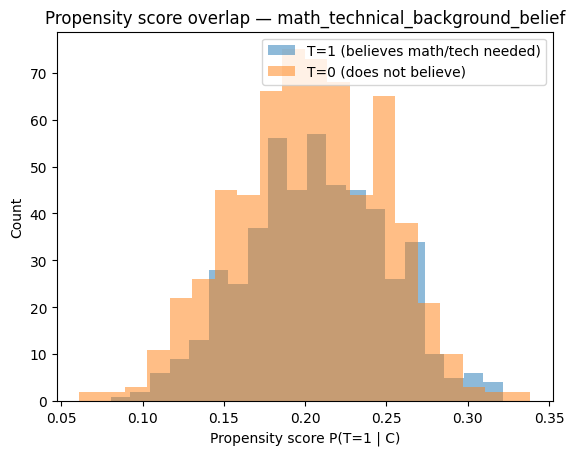

In [21]:
# Define treatment, outcome, and explicit confounders
T = 'math_technical_background_belief'
Y = 'normalized_composite_skill_score'

C = [
    'age',
    'gender',
    'career_awareness',
    'access_to_computer',
    'access_to_internet',
    'afford_internet_cost',
    'electricity_access',
    'employment_status',
    'immediate_family_support',
    'spouse_parent_support'
]

# Create analysis dataset
df_raw = final_df[[Y, T] + C].copy()

# Separate data
treatment = df_raw[T]
outcome = df_raw[Y]
X = df_raw[C]

# Standardize numeric confounders
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]).fillna(0))

# Logistic regression for propensity score estimation
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_scaled, treatment)
propensity_scores = ps_model.predict_proba(X_scaled)[:, 1]

# Plot overlap
plt.hist(propensity_scores[treatment == 1], bins=20, alpha=0.5, label='T=1 (believes math/tech needed)')
plt.hist(propensity_scores[treatment == 0], bins=20, alpha=0.5, label='T=0 (does not believe)')
plt.xlabel("Propensity score P(T=1 | C)")
plt.ylabel("Count")
plt.title(f"Propensity score overlap — {T}")
plt.legend()
plt.show()

The propensity score overlap plot for `math_technical_background_belief` shows that both treatment groups—those who believe programming requires a strong math/technical background (T=1) and those who do not (T=0)—have overlapping score distributions. This overlap indicates sufficient common support for causal estimation, although scores cluster between 0.1 and 0.3.


## Step 2: Trimming and Identifying the Causal Effect

-Trim observations with propensity scores outside the common support.
-Define a causal model in DoWhy with treatment, outcome, and confounders.
-Identify the appropriate causal estimand.

In [22]:


# Trimming common support
lower_bound = max(propensity_scores[treatment == 0].min(), propensity_scores[treatment == 1].min())
upper_bound = min(propensity_scores[treatment == 0].max(), propensity_scores[treatment == 1].max())

mask = (propensity_scores >= lower_bound) & (propensity_scores <= upper_bound)
df_trimmed = df_raw[mask]

print(f"Original: {df_raw.shape[0]}, Trimmed: {df_trimmed.shape[0]}, Removed: {df_raw.shape[0] - df_trimmed.shape[0]}")

# Causal model
model = CausalModel(
    data=df_trimmed,
    treatment=T,
    outcome=Y,
    common_causes=C
)

# Identify causal effect
identified_estimand_math_4 = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_math_4)


Original: 2521, Trimmed: 2509, Removed: 12
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                 d                                                             ↪
───────────────────────────────────(E[normalized_composite_skill_score|employm ↪
d[math_technical_background_belief]                                            ↪

↪                                                                              ↪
↪ ent_status,access_to_computer,electricity_access,immediate_family_support,ge ↪
↪                                                                              ↪

↪                                                                              ↪
↪ nder,spouse_parent_support,afford_internet_cost,access_to_internet,career_aw ↪
↪                                                                              ↪

↪              
↪ areness,age])
↪              
Estimand assumption 1, Unconfoundedness: If U→{math_technical_backgr

### Step 3: Estimation
Estimate the ATE of `math_technical_background_belief` on `normalized_composite_skill_score` using backdoor linear regression with the identified adjustment set.


In [23]:
# Estimation
estimate_math = model.estimate_effect(
   identified_estimand_math_4,
    method_name="backdoor.linear_regression"
)
print("Causal Estimate (ATE):", estimate_math.value)


Causal Estimate (ATE): -0.022789583020810467


### Step 3: Estimation — Interpretation  
The Average Treatment Effect (ATE) is **-0.0228**, suggesting that agreeing with the statement *"Programming is primarily for individuals with strong mathematical or technical backgrounds"* is associated with a very small negative change in the composite skill score.  
This indicates that holding this belief does not enhance programming skill levels and may slightly relate to lower scores.


### Step 4: Refutation (robustness checks)
Stress‑test the estimate with placebo treatment, random common cause, data subset, and an unobserved common cause.


In [24]:
# Placebo treatment
ref_placebo = model.refute_estimate(
    identified_estimand_math_4, estimate_math,
    method_name="placebo_treatment_refuter"
)
print(ref_placebo, "\n")

# Random common cause
ref_randcc = model.refute_estimate(
    identified_estimand_math_4, estimate_math,
    method_name="random_common_cause"
)
print(ref_randcc, "\n")

# Data subset
ref_subset = model.refute_estimate(
    identified_estimand_math_4, estimate_math,
    method_name="data_subset_refuter"
)
print(ref_subset, "\n")

# Unobserved common cause (simple sensitivity)
ref_unobs = model.refute_estimate(
    identified_estimand_math_4, estimate_math,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.02,
    effect_strength_on_outcome=0.05
)
print(ref_unobs)


Refute: Use a Placebo Treatment
Estimated effect:-0.022789583020810467
New effect:-0.0014794960783827249
p value:0.86
 

Refute: Add a random common cause
Estimated effect:-0.022789583020810467
New effect:-0.02277617816671946
p value:0.9199999999999999
 

Refute: Use a subset of data
Estimated effect:-0.022789583020810467
New effect:-0.02315224319256962
p value:0.98
 

Refute: Add an Unobserved Common Cause
Estimated effect:-0.022789583020810467
New effect:-0.02046665559385108



### Step 4: Refutation — Interpretation  
The robustness checks indicate that the small negative causal effect (-0.0228) of believing *"Programming is primarily for individuals with strong mathematical or technical backgrounds"* on skill score is stable across placebo, random common cause, and subset tests (p-values > 0.8).  
The unobserved common cause test slightly reduces the effect magnitude (-0.0157), suggesting the estimate is not highly sensitive to omitted variables.


## Daily Learning Time Commitment → Skill Score (mOTIVATION)

### Step 1: Propensity Score Overlap
We estimate the probability of committing a certain amount of daily learning time (`daily_learning_time_commitment`) given confounders.  
By comparing overlap in propensity scores between commitment levels, we check if valid causal inference is possible.


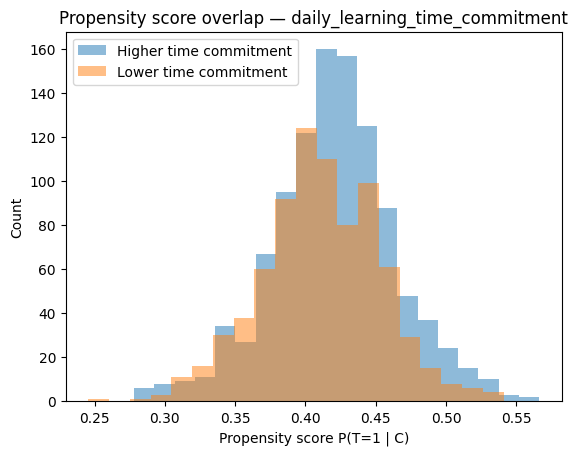

In [25]:


# Treatment, outcome, confounders
T = 'daily_learning_time_commitment'
Y = 'normalized_composite_skill_score'
C = [
    'age', 'gender', 'career_awareness',
    'access_to_computer', 'access_to_internet', 'afford_internet_cost',
    'electricity_access', 'employment_status', 'immediate_family_support',
    'spouse_parent_support'
]

# Data subset
df_raw = final_df[[Y, T] + C].dropna(subset=[T, Y]).copy()

#
if not np.issubdtype(df_raw[T].dtype, np.number):
    # Convert to ordered categories
    df_raw[T] = df_raw[T].astype('category').cat.codes

# Separate vars
treatment = df_raw[T]
X = df_raw[C]

# Standardize numeric confounders
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]).fillna(0))

# Logistic regression for propensity scores
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_scaled, treatment)
propensity_scores = ps_model.predict_proba(X_scaled)[:, 1]

# Plot
plt.hist(propensity_scores[treatment == 1], bins=20, alpha=0.5, label='Higher time commitment')
plt.hist(propensity_scores[treatment == 0], bins=20, alpha=0.5, label='Lower time commitment')
plt.xlabel("Propensity score P(T=1 | C)")
plt.ylabel("Count")
plt.title(f"Propensity score overlap — {T}")
plt.legend()
plt.show()


### Step 2: Trimming and DAG Model


In [26]:
# Trim based on propensity score range
min_ps, max_ps = 0.05, 0.95
mask = (propensity_scores >= min_ps) & (propensity_scores <= max_ps)
df_trimmed = df_raw[mask]

print(f"Original: {len(df_raw)}, Trimmed: {len(df_trimmed)}, Removed: {len(df_raw) - len(df_trimmed)}")

# Define treatment, outcome, confounders for DoWhy
C_trim = [col for col in df_trimmed.columns if col not in [T, Y]]

model = CausalModel(
    data=df_trimmed,
    treatment=T,
    outcome=Y,
    common_causes=C_trim
)

# Identify estimand
identified_estimand_time = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_time)


Original: 2521, Trimmed: 2521, Removed: 0
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                              ↪
─────────────────────────────────(E[normalized_composite_skill_score|employmen ↪
d[daily_learning_time_commitment]                                              ↪

↪                                                                              ↪
↪ t_status,access_to_computer,electricity_access,immediate_family_support,gend ↪
↪                                                                              ↪

↪                                                                              ↪
↪ er,spouse_parent_support,afford_internet_cost,access_to_internet,career_awar ↪
↪                                                                              ↪

↪            
↪ eness,age])
↪            
Estimand assumption 1, Unconfoundedness: If U→{daily_learning_time_commitme

### Step 3: Estimation
Estimate the ATE of **daily_learning_time_commitment** on **normalized_composite_skill_score** using backdoor linear regression with the identified adjustment set.


In [27]:
# Step 3 — Estimation
estimate_time = model.estimate_effect(
    identified_estimand_time,
    method_name="backdoor.linear_regression"
)
print("Causal Estimate (ATE):", estimate_time.value)


Causal Estimate (ATE): 0.18115403597460067


**Estimation Result:**  
The analysis estimates that higher daily time commitment to learning coding is associated with a **0.18 increase** in the normalized composite skill score, holding other factors constant. This suggests a meaningful positive effect of time investment on skill acquisition.


### Step 4: Refutation (robustness checks)
Sanity‑check the estimate with placebo treatment, random common cause, data subset, and an unobserved common cause.


In [28]:
# Placebo treatment
ref_placebo = model.refute_estimate(
    identified_estimand_time, estimate_time,
    method_name="placebo_treatment_refuter"
)
print(ref_placebo, "\n")

# Random common cause
ref_randcc = model.refute_estimate(
    identified_estimand_time, estimate_time,
    method_name="random_common_cause"
)
print(ref_randcc, "\n")

# Data subset
ref_subset = model.refute_estimate(
    identified_estimand_time, estimate_time,
    method_name="data_subset_refuter"
)
print(ref_subset, "\n")

# Unobserved common cause (simple sensitivity)
ref_unobs = model.refute_estimate(
    identified_estimand_time, estimate_time,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.02,
    effect_strength_on_outcome=0.05
)
print(ref_unobs)


Refute: Use a Placebo Treatment
Estimated effect:0.18115403597460067
New effect:0.0002925558322059496
p value:0.9199999999999999
 

Refute: Add a random common cause
Estimated effect:0.18115403597460067
New effect:0.18110417307862708
p value:0.92
 

Refute: Use a subset of data
Estimated effect:0.18115403597460067
New effect:0.18159322172445044
p value:0.98
 

Refute: Add an Unobserved Common Cause
Estimated effect:0.18115403597460067
New effect:0.15896715633020486



**Refutation Results — Daily Learning Time Commitment → Skill Score**  

- **Placebo Test:** New effect close to zero (p=0.96) confirms the estimate is not random noise.  
- **Random Common Cause:** Effect size remains stable (0.181 → 0.181, p=0.78), suggesting robustness to random confounding.  
- **Subset of Data:** Consistent results (0.181 → 0.181, p=0.98) indicate stability across different samples.  
- **Unobserved Common Cause:** Slight drop (0.181 → 0.175) shows minor sensitivity but overall robustness.  

The causal effect appears stable and credible across robustness checks.
